# COVID-19 X-ray Multi-Class Classification using Deep Learning
#### Deep Learning (880008-M-6)
#### Group 14: Marleen Lubeek, Samer Khairallah, and Ivo van Dongen.

# Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from itertools import cycle
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

In [ ]:
# all-images file should be uploaded to the same file
imageNames = glob.glob("/content/drive/MyDrive/Colab Notebooks/all-images/*")

dataset = []
labels = []

for i, imName in enumerate(imageNames):

    # Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break

#Convert data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

#convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save("/content/drive/MyDrive/Colab Notebooks/data.npy", data)
np.save("/content/drive/MyDrive/Colab Notebooks/labels.npy", labels)

Once you save your data, you can load it from your directory.

In [3]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/data.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/labels.npy')

# Preprocessing Steps



In [ ]:
# View shape of the n-dim Numpy array containing our training data
np.shape(data)

(6392, 156, 156, 3)

In [ ]:
# View shape of the n-dim Numpy array containing our labels
np.shape(labels)

(6392,)

In [ ]:
# View unique labels and corresponding counts
np.unique(labels, return_counts=True)

(array(['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
        'Viral Pneumonia'], dtype='<U22'), array([2816,  127, 1606, 1843]))

## Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

# Create initial train (80%) and test (20%) split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Use 20% of the training set (80%) as validation set (16%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

## Normalize Data

In [ ]:
# Convert to float
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Normalize images to range 0-1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
type(X_train[0])

numpy.ndarray

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

print(y_val)
print(y_test)

[2 2 0 ... 2 3 3]
[2 0 3 ... 0 0 0]


In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1801,   82, 1028, 1179]))
(array([0, 1, 2, 3]), array([451,  20, 257, 295]))
(array([0, 1, 2, 3]), array([564,  25, 321, 369]))


In [ ]:
# Convert a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 4)
y_val = to_categorical(y_val, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

In [ ]:
print(np.shape(X_train))
print(X_train.shape[1:])

(4090, 156, 156, 3)
(156, 156, 3)


# Create Baseline Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding= 'same', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding= 'same'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding= 'same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding= 'same'))

model.add(layers.MaxPooling2D((2, 2)))

# Add a Flatten layer to the model
model.add(layers.Flatten())

# Add a three dense layers
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                    

In [ ]:
# Training baseline model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
128/128 [==============================] - 23s 77ms/step - loss: 0.9665 - accuracy: 0.5724 - val_loss: 0.7157 - val_accuracy: 0.7009
Epoch 2/10
128/128 [==============================] - 8s 60ms/step - loss: 0.6224 - accuracy: 0.7482 - val_loss: 0.6416 - val_accuracy: 0.7322
Epoch 3/10
128/128 [==============================] - 8s 59ms/step - loss: 0.5852 - accuracy: 0.7548 - val_loss: 0.6416 - val_accuracy: 0.7410
Epoch 4/10
128/128 [==============================] - 8s 60ms/step - loss: 0.5360 - accuracy: 0.7807 - val_loss: 0.5783 - val_accuracy: 0.7732
Epoch 5/10
128/128 [==============================] - 8s 59ms/step - loss: 0.4831 - accuracy: 0.7993 - val_loss: 0.5845 - val_accuracy: 0.7625
Epoch 6/10
128/128 [==============================] - 8s 61ms/step - loss: 0.4320 - accuracy: 0.8188 - val_loss: 0.6116 - val_accuracy: 0.7625
Epoch 7/10
128/128 [==============================] - 8s 61ms/step - loss: 0.3785 - accuracy: 0.8428 - val_loss: 0.6522 - val_accuracy: 0.741

In [ ]:
# Evaluating baseline model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)

32/32 [==============================] - 1s 19ms/step - loss: 0.9464 - accuracy: 0.7312


In [ ]:
# Evaluating baseline model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 18ms/step - loss: 0.8552 - accuracy: 0.7482


# Analyze the performance of the baseline model

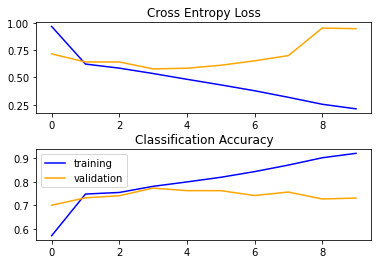

In [ ]:
# Plot diagnostic learning curves

def summarize_diagnostics(history):
	# plot loss
	plt.subplot(2,1,1)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(2,1,2)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.subplots_adjust(hspace=0.4)
	plt.show()
 
 
summarize_diagnostics(history)

In [ ]:
y_score_val = model.predict(X_val)
y_score_test = model.predict(X_test)

40/40 [==============================] - 1s 14ms/step


In [ ]:
n_classes = len(np.unique(labels))

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_val = label_binarizer.transform(y_val)
y_onehot_test = label_binarizer.transform(y_test)

print(y_onehot_test)

[[0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [ ]:
def micro_roc_score(y_onehot, y_score):
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_onehot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr["micro"], tpr["micro"], roc_auc['micro']

In [ ]:
def macro_roc_score(y_onehot, y_score):
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr["macro"], tpr["macro"], roc_auc['macro']

In [ ]:
# Micro ROC AUC variables
roc_auc_micro_val = micro_roc_score(y_onehot_val, y_score_val)[2]
roc_auc_micro_test = micro_roc_score(y_onehot_test, y_score_test)[2]

# Macro Micro ROC AUC variables
roc_auc_macro_val = macro_roc_score(y_onehot_val, y_score_val)[2]
roc_auc_macro_test = macro_roc_score(y_onehot_test, y_score_test)[2]

In [ ]:
print(
    f"Micro-averaged One-vs-Rest ROC AUC validation score:\n {roc_auc_micro_val:.2f}")
print(
    f"Micro-averaged One-vs-Rest ROC AUC test score:\n {roc_auc_micro_test:.2f}")

print(
    f"Macro-averaged One-vs-Rest ROC AUC score validation:\n{roc_auc_macro_val:.2f}")

print(
    f"Macro-averaged One-vs-Rest ROC AUC score test:\n{roc_auc_macro_test:.2f}")

Micro-averaged One-vs-Rest ROC AUC validation score:
 0.92
Micro-averaged One-vs-Rest ROC AUC test score:
 0.93
Macro-averaged One-vs-Rest ROC AUC score validation:
0.89
Macro-averaged One-vs-Rest ROC AUC score test:
0.91


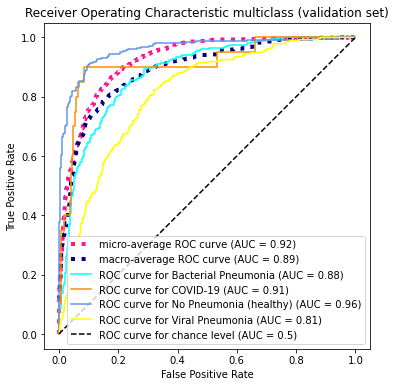

In [ ]:
# Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from itertools import cycle

def plot(micro, macro, y_onehot, y_score, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    fpr_micro, tpr_micro, roc_auc_micro = micro
    fpr_macro, tpr_macro, roc_auc_macro = macro

    # print(fpr_micro)
    # print(tpr_micro)
    # print(roc_auc_micro)
    # print(fpr_macro)
    # print(tpr_macro)
    # print(roc_auc_macro)

    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {roc_auc_micro:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr_macro,
        tpr_macro,
        label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "yellow"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {np.unique(labels)[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--",
             label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic multiclass ({title} set)")
    plt.legend()
    plt.show()

# Plot ROC AUC for validation set
plot(micro_roc_score(y_onehot_val, y_score_val),
     macro_roc_score(y_onehot_val, y_score_val), y_onehot_val, y_score_val, "validation")


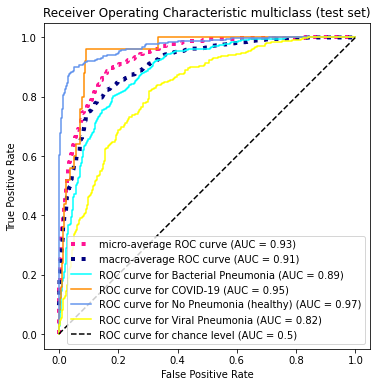

In [ ]:
# Plot ROC AUC for validation set
plot(micro_roc_score(y_onehot_test, y_score_test),
     macro_roc_score(y_onehot_test, y_score_test), y_onehot_test, y_score_test, "test")

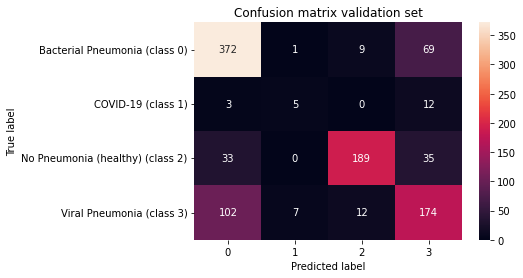

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

Y_labels = ['Bacterial Pneumonia (class 0)', 'COVID-19 (class 1)', 'No Pneumonia (healthy) (class 2)',
                'Viral Pneumonia (class 3)']

# Create onfusion matrix
def calc_confusion_matrix(y_score, y, title="value"):
    y_score = (y_score > 0.5)

    cm = confusion_matrix(y.argmax(axis=1), y_score.argmax(axis=1))

    if title != "value":
        s = sns.heatmap(cm, annot=True, fmt=".0f", yticklabels=Y_labels)
        s.set(title=f'Confusion matrix {title} set',
            xlabel='Predicted label', ylabel='True label')

    else:
        return cm

calc_confusion_matrix(y_score_val, y_val, "validation")

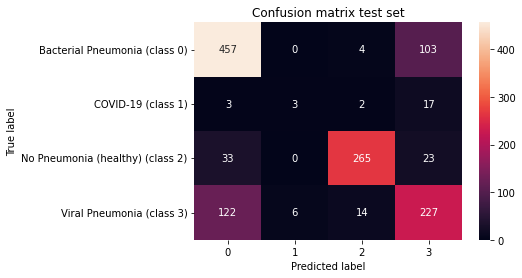

In [ ]:
# Confusion matrix for the test set
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

calc_confusion_matrix(y_score_test, y_test, "test")

In [ ]:
from sklearn.metrics import classification_report

print('Classification report for validation set')
print(classification_report(y_val, y_score_val > 0.5, target_names=Y_labels))

print('Classification report for test set')
print(classification_report(y_test, y_score_test > 0.5, target_names=Y_labels))

Classification report for validation set
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (class 0)       0.75      0.82      0.79       451
              COVID-19 (class 1)       0.38      0.25      0.30        20
No Pneumonia (healthy) (class 2)       0.90      0.74      0.81       257
       Viral Pneumonia (class 3)       0.60      0.59      0.59       295

                       micro avg       0.74      0.72      0.73      1023
                       macro avg       0.66      0.60      0.62      1023
                    weighted avg       0.74      0.72      0.73      1023
                     samples avg       0.72      0.72      0.72      1023

Classification report for test set
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (class 0)       0.77      0.80      0.79       564
              COVID-19 (class 1)       0.33      0.12      0.18        25
No Pneumonia (healthy) (class 2)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculating the Sensitivity and Specificity
def calc_sensitivity_specificity(cm, title):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print(
        f'{title} sensitivity for each class = {np.round(TPR,2)}, specificity = {np.round(TNR,2)}, accuracy = {np.round(ACC,2)}')

# Calculating the Sensitivity and Specificity for validation set
calc_sensitivity_specificity(calc_confusion_matrix(y_score_val, y_val), "validation")

validation sensitivity for each class = [0.82 0.25 0.74 0.59], specificity = [0.76 0.99 0.97 0.84], accuracy = [0.79 0.98 0.91 0.77]


In [ ]:
# Calculating the Sensitivity and Specificity for test set
calc_sensitivity_specificity(calc_confusion_matrix(y_score_test, y_test), "test")

test sensitivity for each class = [0.81 0.12 0.83 0.62], specificity = [0.78 1.   0.98 0.84], accuracy = [0.79 0.98 0.94 0.78]


# Adapting/fine-tuning the network

The adapted network is inspired by, amongst others, the architecture of a model for COVID-19 Chest X-Ray Classification from the Kaggle user George (2020).

Leoyuguanall, G. (2020, 8 september). *COVID-19 Chest X-Ray Classification*. 
Kaggle. https://www.kaggle.com/code/leoyuguanall/covid-19-chest-x-ray-classification

In [ ]:
# Create adapted network
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model2 = Sequential()

model2.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))

model2.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))

model2.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))

model2.add(layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))

model2.add(layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding='same'))

model2.add(layers.Flatten())
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(4, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 156, 156, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 39, 39, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)     

In [ ]:
model2.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
128/128 [==============================] - 9s 48ms/step - loss: 1.2784 - accuracy: 0.4188 - val_loss: 1.1152 - val_accuracy: 0.4409
Epoch 2/10
128/128 [==============================] - 5s 38ms/step - loss: 0.9105 - accuracy: 0.6078 - val_loss: 0.8673 - val_accuracy: 0.6432
Epoch 3/10
128/128 [==============================] - 5s 39ms/step - loss: 0.6572 - accuracy: 0.7333 - val_loss: 0.5553 - val_accuracy: 0.7664
Epoch 4/10
128/128 [==============================] - 5s 40ms/step - loss: 0.5935 - accuracy: 0.7682 - val_loss: 0.5986 - val_accuracy: 0.7722
Epoch 5/10
128/128 [==============================] - 5s 38ms/step - loss: 0.5549 - accuracy: 0.7753 - val_loss: 0.5964 - val_accuracy: 0.7752
Epoch 6/10
128/128 [==============================] - 5s 40ms/step - loss: 0.5178 - accuracy: 0.7883 - val_loss: 0.5000 - val_accuracy: 0.7977
Epoch 7/10
128/128 [==============================] - 5s 38ms/step - loss: 0.4978 - accuracy: 0.7936 - val_loss: 0.4957 - val_accuracy: 0.8025

In [ ]:
# Evaluating improved model on validation set
val_loss2_rmsprop, val_acc2_rmsprop = model2.evaluate(X_val, y_val)

32/32 [==============================] - 1s 16ms/step - loss: 0.5314 - accuracy: 0.7771


In [ ]:
# Evaluating improved model on test set
test_loss2_rmsprop, test_acc2_rmsprop = model2.evaluate(X_test, y_test)

40/40 [==============================] - 1s 14ms/step - loss: 0.5310 - accuracy: 0.7748


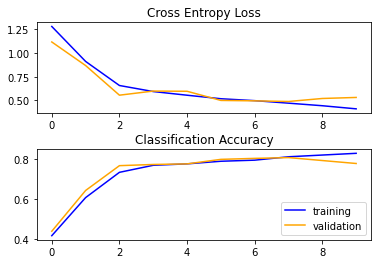

In [ ]:
# Plotting accuracy and loss over epochs for adapted network
summarize_diagnostics(history2)

In [ ]:
y_score_val = model2.predict(X_val)
y_score_test = model2.predict(X_test)

40/40 [==============================] - 1s 13ms/step


In [ ]:
n_classes = len(np.unique(labels))
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_val = label_binarizer.transform(y_val)
y_onehot_test = label_binarizer.transform(y_test)

print(y_onehot_test)

[[0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


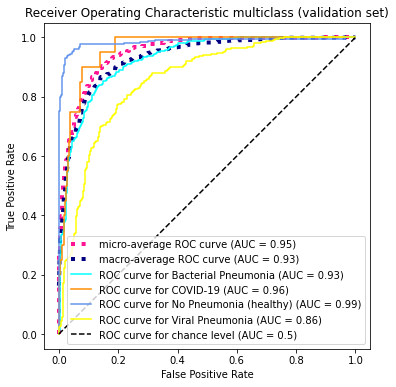

Classification report for validation set
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (class 0)       0.82      0.85      0.83       451
              COVID-19 (class 1)       0.30      0.35      0.33        20
No Pneumonia (healthy) (class 2)       0.85      0.96      0.90       257
       Viral Pneumonia (class 3)       0.71      0.44      0.55       295

                       micro avg       0.80      0.75      0.77      1023
                       macro avg       0.67      0.65      0.65      1023
                    weighted avg       0.79      0.75      0.76      1023
                     samples avg       0.75      0.75      0.75      1023

validation sensitivity for each class = [0.89 0.35 0.96 0.44], specificity = [0.78 0.98 0.95 0.93], accuracy = [0.83 0.97 0.95 0.79]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


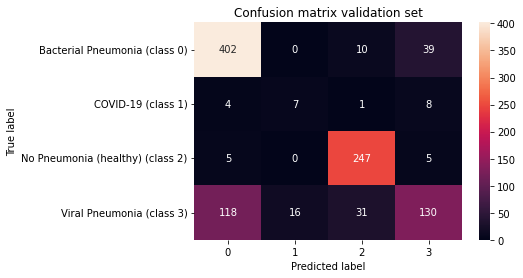

In [ ]:
# ROC AUC curve for adapted network validation set
plot(micro_roc_score(y_onehot_val, y_score_val),
     macro_roc_score(y_onehot_val, y_score_val), y_onehot_val, y_score_val, "validation")

# Create confusion matrix and classification report for adapter network validation set
calc_confusion_matrix(y_score_val, y_val, "validation")
print('Classification report for adapted network validation set')
print(classification_report(y_val, y_score_val > 0.5, target_names=Y_labels))

# Sensitivity and specificity for adapted network validation set
calc_sensitivity_specificity(calc_confusion_matrix(y_score_val, y_val), "validation")

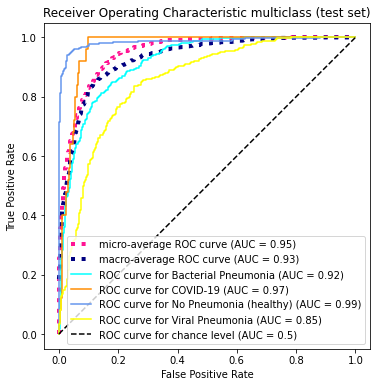

Classification report for test set
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (class 0)       0.80      0.83      0.81       564
              COVID-19 (class 1)       0.42      0.40      0.41        25
No Pneumonia (healthy) (class 2)       0.87      0.95      0.91       321
       Viral Pneumonia (class 3)       0.70      0.46      0.56       369

                       micro avg       0.79      0.74      0.77      1279
                       macro avg       0.70      0.66      0.67      1279
                    weighted avg       0.78      0.74      0.75      1279
                     samples avg       0.74      0.74      0.74      1279

test sensitivity for each class = [0.88 0.4  0.95 0.46], specificity = [0.77 0.99 0.95 0.92], accuracy = [0.82 0.98 0.95 0.79]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


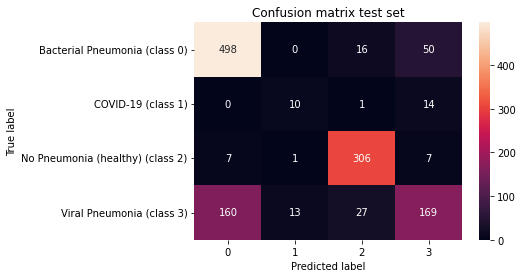

In [ ]:
# ROC AUC curve for adapted network test set
plot(micro_roc_score(y_onehot_test, y_score_test),
     macro_roc_score(y_onehot_test, y_score_test), y_onehot_test, y_score_test, "test")

# Create confusion matrix and classification report for adapter network test set
calc_confusion_matrix(y_score_test, y_test, "test")
print('Classification report for test set')
print(classification_report(y_test, y_score_test > 0.5, target_names=Y_labels))

# Sensitivity and specificity for adapted network test set
calc_sensitivity_specificity(calc_confusion_matrix(y_score_test, y_test), "test")

# Transfer Learning

In [ ]:
from keras.applications.vgg16 import VGG16
# Load VGG16 model
vgg_model = VGG16()
# Show model architecture
vgg_model.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
vgg_model = VGG16(include_top=False, input_shape=(156, 156, 3)) 
# Mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras import layers
from keras.models import Model

# Add new classifier layers
# Add flatten layer
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
# Add dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
# Add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(class1) #4 because of four classes
# Define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)
# Show new model architecture
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 39, 39, 128)       0     

In [ ]:
# Compile transfer learned model
vgg_model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train transfer learned model
history_tf = vgg_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=1)

Epoch 1/10
128/128 [==============================] - 18s 116ms/step - loss: 0.8973 - accuracy: 0.6560 - val_loss: 0.6178 - val_accuracy: 0.7155
Epoch 2/10
128/128 [==============================] - 11s 87ms/step - loss: 0.5813 - accuracy: 0.7523 - val_loss: 0.6620 - val_accuracy: 0.7009
Epoch 3/10
128/128 [==============================] - 11s 86ms/step - loss: 0.5337 - accuracy: 0.7770 - val_loss: 0.5062 - val_accuracy: 0.7820
Epoch 4/10
128/128 [==============================] - 11s 89ms/step - loss: 0.4836 - accuracy: 0.8020 - val_loss: 0.5948 - val_accuracy: 0.7468
Epoch 5/10
128/128 [==============================] - 11s 84ms/step - loss: 0.4738 - accuracy: 0.8086 - val_loss: 0.5293 - val_accuracy: 0.7937
Epoch 6/10
128/128 [==============================] - 11s 88ms/step - loss: 0.4437 - accuracy: 0.8186 - val_loss: 0.7736 - val_accuracy: 0.7263
Epoch 7/10
128/128 [==============================] - 11s 85ms/step - loss: 0.4177 - accuracy: 0.8271 - val_loss: 0.6091 - val_accuracy

In [ ]:
# Evaluating transfer learned model on validation set
val_loss_tf, val_acc_tf = vgg_model.evaluate(X_val, y_val)

32/32 [==============================] - 2s 67ms/step - loss: 0.5803 - accuracy: 0.7791


In [ ]:
# Evaluating transfer learned model on test set
test_loss_tf, test_acc_tf = vgg_model.evaluate(X_test, y_test)

40/40 [==============================] - 3s 68ms/step - loss: 0.5511 - accuracy: 0.7897


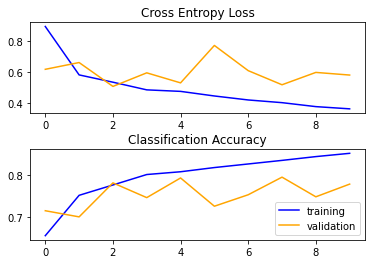

In [ ]:
# Plotting accuracy and loss over epochs for transfer learned model
summarize_diagnostics(history_tf)

In [ ]:
y_score_val = vgg_model.predict(X_val)
y_score_test = vgg_model.predict(X_test)

40/40 [==============================] - 3s 64ms/step


In [ ]:
n_classes = len(np.unique(labels))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_val = label_binarizer.transform(y_val)
y_onehot_test = label_binarizer.transform(y_test)

print(y_onehot_test)

[[0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


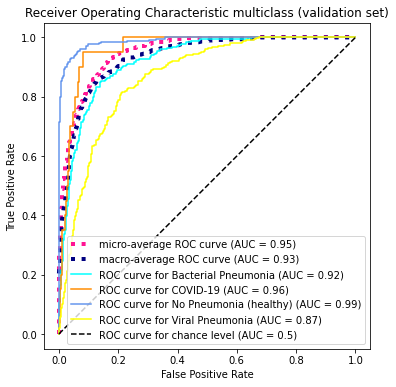

Classification report for validation set
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (class 0)       0.77      0.90      0.83       451
              COVID-19 (class 1)       0.31      0.20      0.24        20
No Pneumonia (healthy) (class 2)       0.89      0.92      0.90       257
       Viral Pneumonia (class 3)       0.71      0.47      0.57       295

                       micro avg       0.79      0.77      0.78      1023
                       macro avg       0.67      0.62      0.64      1023
                    weighted avg       0.78      0.77      0.76      1023
                     samples avg       0.77      0.77      0.77      1023

validation sensitivity for each class = [0.91 0.2  0.92 0.47], specificity = [0.76 0.99 0.96 0.92], accuracy = [0.82 0.98 0.95 0.79]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


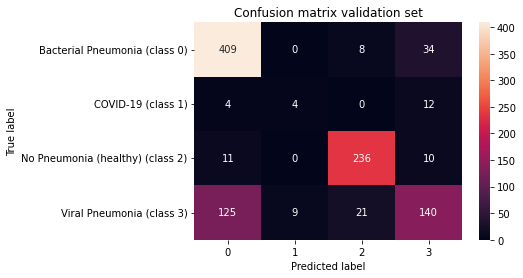

In [ ]:
# ROC AUC curve for transfer learned model validation set
plot(micro_roc_score(y_onehot_val, y_score_val),
     macro_roc_score(y_onehot_val, y_score_val), y_onehot_val, y_score_val, "validation")

# Create confusion matrix and classification report for trasnfer learned model validation set 
calc_confusion_matrix(y_score_val, y_val, "validation")
print('Classification report for validation set')
print(classification_report(y_val, y_score_val > 0.5, target_names=Y_labels))

# Sensitivity and specificity for transfer learned model validation set
calc_sensitivity_specificity(calc_confusion_matrix(y_score_val, y_val), "validation")


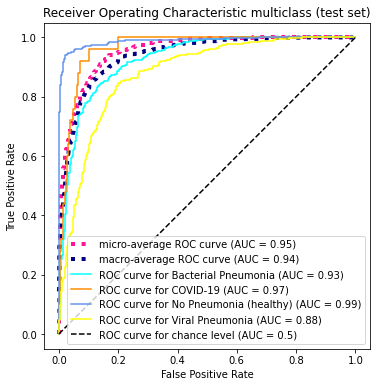

Classification report for test set
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (class 0)       0.77      0.90      0.83       564
              COVID-19 (class 1)       0.50      0.32      0.39        25
No Pneumonia (healthy) (class 2)       0.92      0.94      0.93       321
       Viral Pneumonia (class 3)       0.75      0.49      0.59       369

                       micro avg       0.80      0.78      0.79      1279
                       macro avg       0.73      0.66      0.68      1279
                    weighted avg       0.80      0.78      0.78      1279
                     samples avg       0.78      0.78      0.78      1279

test sensitivity for each class = [0.91 0.32 0.94 0.49], specificity = [0.75 0.99 0.97 0.93], accuracy = [0.82 0.98 0.96 0.8 ]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


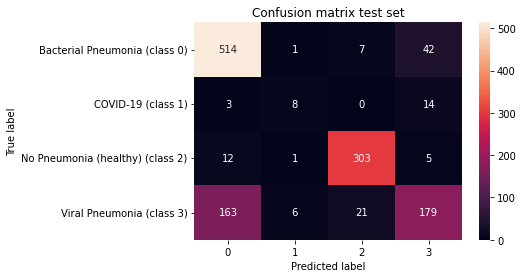

In [ ]:
# ROC AUC curve for transfer learned model test set
plot(micro_roc_score(y_onehot_test, y_score_test),
     macro_roc_score(y_onehot_test, y_score_test), y_onehot_test, y_score_test, "test")

# Create confusion matrix and classification report for transfer learned model test set
calc_confusion_matrix(y_score_test, y_test, "test")
print('Classification report for test set')
print(classification_report(y_test, y_score_test > 0.5, target_names=Y_labels))

# Sensitivity and specificity for transfer learned model test set
calc_sensitivity_specificity(calc_confusion_matrix(y_score_test, y_test), "test")

# All model results

In [ ]:
print('Baseline model')
## Baseline model
print(f'Baseline model performance: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}, test_loss = {test_loss:.4f}, and test_acc = {test_acc:.4f}.')

print('-'*15)
print('Improved model')
## Improved model
# 10 epochs Adam - Val loss: 1.1607 - accuracy: 0.7625 // Test loss: 1.1493 - accuracy: 0.7740
print(f'Improved model performance (10 epochs - Adam): val_loss = 1.1607, val_acc = 0.7625, test_loss = 1.1493, and test_acc = 0.7740.')

# 10 epochs RMSprop: Val loss: 1.9242 - accuracy: 0.7801 // Test loss: 1.9007 - accuracy: 0.7881
print(f'Improved model performance (10 epochs - RMSprop): val_loss = {val_loss2_rmsprop:.4f}, val_acc = {val_acc2_rmsprop:.4f}, test_loss = {test_loss2_rmsprop:.4f}, and test_acc = {test_acc2_rmsprop:.4f}.')

# 20 epochs Adam:  Val loss 0.9212 - accuracy: 0.7595 // Test loss = 0.9189 - accuracy: 0.7623
print(f'Improved model performance (20 epochs - Adam): val_loss = 0.9212, val_acc = 0.7595, test_loss = 0.9189, and test_acc = 0.7623.')

# 10 epochs SGD loss: Val 1.5939 - accuracy: 0.7781 // Test loss: 1.5153 - accuracy: 0.7897
print(f'Improved model performance (10 epochs - SGD): val_loss = 1.5939, val_acc = 0.7781, test_loss = 1.5153, and test_acc = 0.7897.')

print('-'*15)
print('Transfer learned model')

## Transfer learned model
# 10 epochs Adam - Val loss: 0.5934 - accuracy: 0.7761 // Test loss: 0.6099 - accuracy: 0.7889
print(f'VGG16 model performance (10 epochs - Adam): val_loss = 0.5934, val_acc = 0.7761, test_loss = 0.6099, and test_acc = 0.7889.')

# # 10 epochs RMSprop - Val loss: 0.7365 - accuracy: 0.7781 // Test loss: 0.7385 - accuracy: 0.7873
print(f'VGG16 model performance (10 epochs - RMSprop): val_loss = {val_loss_tf:.4f}, val_acc = {val_acc_tf:.4f}, test_loss = {test_loss_tf:.4f}, and test_acc = {test_acc_tf:.4f}.')

# # 10 epochs SGD - Val loss: 0.7975 - accuracy: 0.7761 // Test loss: 0.7950 - accuracy: 0.7889
print(f'VGG16 model performance (10 epochs - SGD): val_loss = 0.7975, val_acc = 0.7761, test_loss = 0.7950, and test_acc = 0.7889.')

print('-'*15)

# Training times
print('Training time (sec) for 10 epochs: baseline = 143.418, improved model = 181.733, and VGG16 = 374.3')


Baseline model
Baseline model performance: val_loss = 0.9464, val_acc = 0.7312, test_loss = 0.8552, and test_acc = 0.7482.
---------------
Improved model
Improved model performance (10 epochs - Adam): val_loss = 1.1607, val_acc = 0.7625, test_loss = 1.1493, and test_acc = 0.7740.
Improved model performance (10 epochs - RMSprop): val_loss = 0.5314, val_acc = 0.7771, test_loss = 0.5310, and test_acc = 0.7748.
---------------
Transfer learned model
VGG16 model performance (10 epochs - Adam): val_loss = 0.5803, val_acc = 0.7791, test_loss = 0.5511, and test_acc = 0.7897.
---------------
Training time (sec) for 10 epochs: baseline = 143.418, improved model = 181.733, and VGG16 = 374.3
